In [6]:
# # Discard the output of this cell.
# #%%capture

# # Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-21zh0_yc/pafy_0e8200f6a96c4b0f8537b7cf5045b04f
  Running command git clone -q https://github.com/TahaAnwar/pafy.git /tmp/pip-install-21zh0_yc/pafy_0e8200f6a96c4b0f8537b7cf5045b04f
  Created wheel for pafy: filename=pafy-0.5.5-py2.py3-none-any.whl size=35706 sha256=9df5362e00ec6a5cbc4648298cd7774eedba75b43a4654072914bcf94dbd220e
  Stored in directory: /tmp/pip-ephem-wheel-cache-dgh73iep/wheels/64/82/dd/3d7823b3bbbe1aca9b30f8cf0d6bb6c1b72ccd95e3360f8190
Successfully built pafy


In [7]:
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 15.3 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=bacbeea9d3690ed62f2e6462c02ec7bf6d07bfad6f25e939f83d0168759d4be5
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


In [9]:
!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [10]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3710976/45929032 bytes (8.1%)7815168/45929032 bytes (17.0%)11935744/45929032 bytes (26.0%)16031744/45929032 bytes (34.9%)20258816/45929032 bytes (44.1%)24420352/45929032 bytes (53.2%)28631040/45929032 bytes (62.3%)32571392/45929032 bytes (70.9%)36569088/45929032 bytes (79.6%)40697856/45929032 bytes (88.6%)44900352/45929032 bytes (97.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [11]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


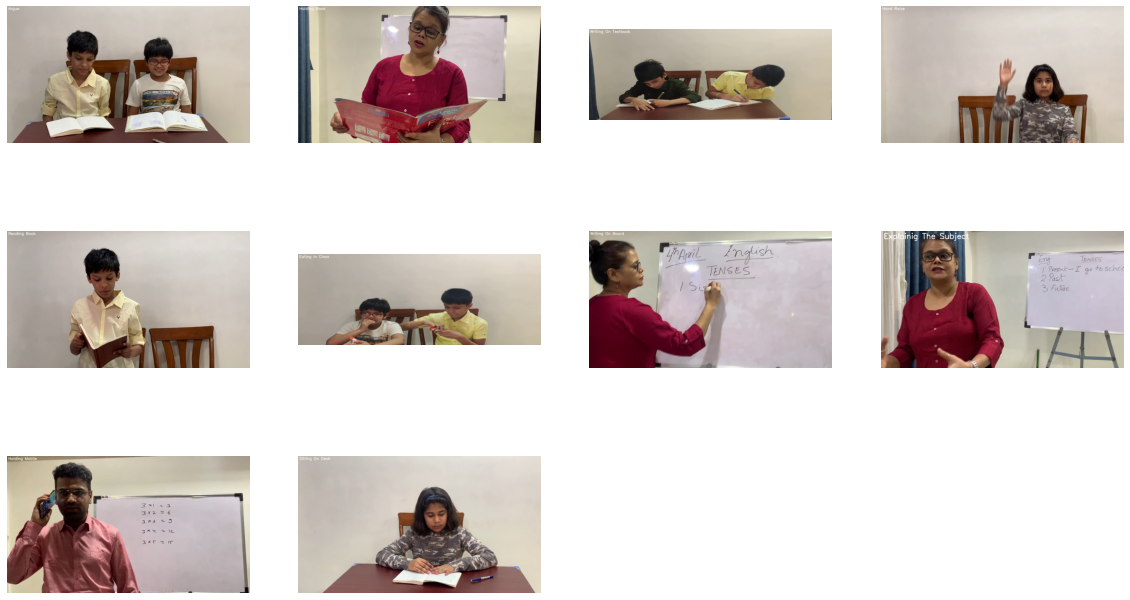

In [13]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/Dataset_Classroom (1)"

# Get the names of all classes/categories.
all_classes_names = os.listdir(DATASET_DIR)

# Generate a list of11 values.  
# where 11 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 10)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{DATASET_DIR}/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{DATASET_DIR}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [14]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "/content/drive/MyDrive/Dataset_Classroom (1)"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = [
    "Argue",
    "Eating In Class",
    "Explainig The Subject",
    "Hand Raise",
    "Holding Book",
    "Holding Mobile",
    "Reading Book",
    "Sitting On Desk",
    "Writing On Board",
    "Writing On Textbook"
]

In [15]:
# def frames_extraction(video_path):
#     '''
#     This function will extract the required frames from a video after resizing and normalizing them.
#     Args:
#         video_path: The path of the video in the disk, whose frames are to be extracted.
#     Returns:
#         frames_list: A list containing the resized and normalized frames of the video.
#     '''

#     # Declare a list to store video frames.
#     frames_list = []
    
#     # Read the Video File using the VideoCapture object.
#     video_reader = cv2.VideoCapture(video_path)

#     # Get the total number of frames in the video.
#     video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

#     # Calculate the the interval after which frames will be added to the list.
#     skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

#     # Iterate through the Video Frames.
#     for frame_counter in range(SEQUENCE_LENGTH):

#         # Set the current frame position of the video.
#         video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

#         # Reading the frame from the video. 
#         success, frame = video_reader.read() 

#         # Check if Video frame is not successfully read then break the loop
#         if not success:
#             break

#         # Resize the Frame to fixed height and width.
#         resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
#         # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
#         normalized_frame = resized_frame / 255
        
#         # Append the normalized frame into the frames list
#         frames_list.append(normalized_frame)
    
#     # Release the VideoCapture object. 
#     video_reader.release()

#     # Return the frames list.
#     return frames_list

In [16]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16

# Calculate the the interval after which frames will be added to the list.
skip_frames_window = 5


def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    sequence_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Iterate through the Video Frames.
    for frame_counter in range(0, video_frames_count, skip_frames_window):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

        if len(frames_list) == SEQUENCE_LENGTH:
          sequence_list.append(frames_list)
          frames_list = []
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return sequence_list

In [17]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            sequence_list = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(sequence_list) > 0:
                for squence in sequence_list:
                  # Append the data to their repective lists.
                  features.append(squence)
                  labels.append(class_index)
                  video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [18]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Argue
Extracting Data of Class: Eating In Class
Extracting Data of Class: Explainig The Subject
Extracting Data of Class: Hand Raise
Extracting Data of Class: Holding Book
Extracting Data of Class: Holding Mobile
Extracting Data of Class: Reading Book
Extracting Data of Class: Sitting On Desk
Extracting Data of Class: Writing On Board
Extracting Data of Class: Writing On Textbook


In [19]:
features.shape

(221, 16, 128, 128, 3)

In [20]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [21]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(
    features, 
    one_hot_encoded_labels,
    test_size=0.25, 
    shuffle=True,
    random_state=seed_constant
)

In [22]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Return the constructed convlstm model.
    return model

In [23]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
# Display the success message. 
print("Model Created Successfully!")

# Display the models summary.
convlstm_model.summary()

Model Created Successfully!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 16, 126, 126, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 16, 63, 63, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 16, 63, 63, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 16, 61, 61, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 16, 31, 31, 8)    0         
 3D)                                                             
                            

In [24]:
# plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [25]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode='min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=2,
    shuffle=True,
    validation_split=0.2,
    callbacks = [early_stopping_callback]
)

Epoch 1/50
66/66 [==============================] - 29s 236ms/step - loss: 2.2879 - accuracy: 0.1364 - val_loss: 2.2380 - val_accuracy: 0.2121
Epoch 2/50
66/66 [==============================] - 15s 222ms/step - loss: 1.6637 - accuracy: 0.5152 - val_loss: 1.2468 - val_accuracy: 0.6970
Epoch 3/50
66/66 [==============================] - 15s 221ms/step - loss: 0.7558 - accuracy: 0.7348 - val_loss: 1.3049 - val_accuracy: 0.6364
Epoch 4/50
66/66 [==============================] - 16s 237ms/step - loss: 0.5776 - accuracy: 0.8333 - val_loss: 1.0958 - val_accuracy: 0.7273
Epoch 5/50
66/66 [==============================] - 14s 219ms/step - loss: 0.3121 - accuracy: 0.9167 - val_loss: 1.3257 - val_accuracy: 0.7576
Epoch 6/50
66/66 [==============================] - 14s 219ms/step - loss: 0.0942 - accuracy: 0.9621 - val_loss: 1.7839 - val_accuracy: 0.7576
Epoch 7/50
66/66 [==============================] - 14s 219ms/step - loss: 0.1247 - accuracy: 0.9697 - val_loss: 1.7661 - val_accuracy: 0.6667

In [26]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 278ms/step - loss: 2.3150 - accuracy: 0.1429


In [27]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [28]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

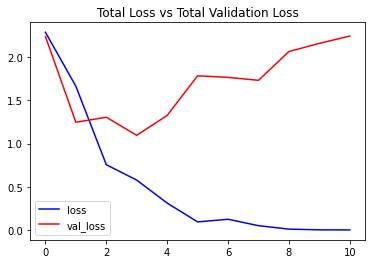

In [29]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

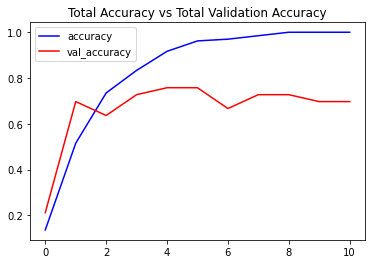

In [30]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [31]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [32]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 16, 128, 128, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 32, 32, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 8, 8, 32)    

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

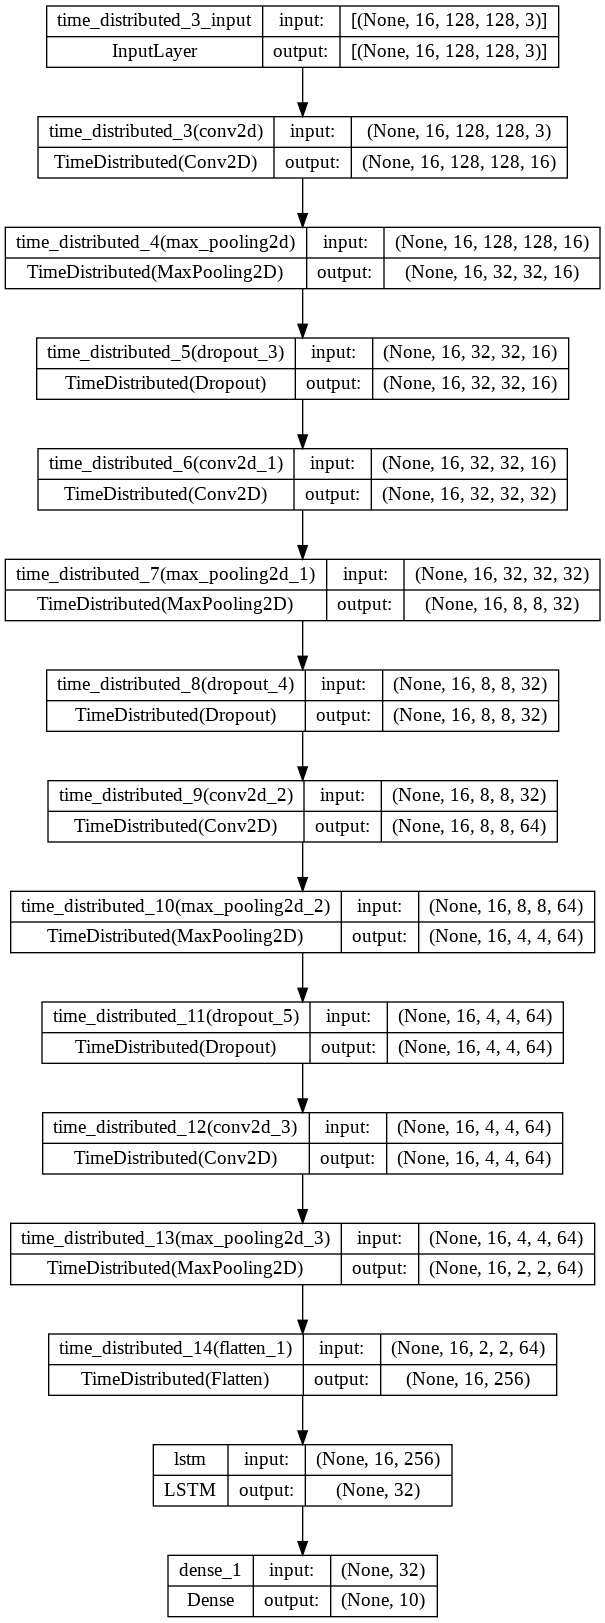

In [33]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [34]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(
    x=features_train, 
    y=labels_train, 
    epochs=30, 
    batch_size=2,
    shuffle=True, 
    validation_split=0.2, 
    callbacks=[early_stopping_callback]
)

Epoch 1/30
66/66 [==============================] - 4s 22ms/step - loss: 2.3406 - accuracy: 0.1364 - val_loss: 2.2460 - val_accuracy: 0.3030
Epoch 2/30
66/66 [==============================] - 1s 12ms/step - loss: 2.2452 - accuracy: 0.1742 - val_loss: 2.2122 - val_accuracy: 0.3333
Epoch 3/30
66/66 [==============================] - 1s 12ms/step - loss: 2.2360 - accuracy: 0.2197 - val_loss: 2.1084 - val_accuracy: 0.4242
Epoch 4/30
66/66 [==============================] - 1s 12ms/step - loss: 1.8835 - accuracy: 0.3409 - val_loss: 1.2308 - val_accuracy: 0.6364
Epoch 5/30
66/66 [==============================] - 1s 12ms/step - loss: 1.1894 - accuracy: 0.6667 - val_loss: 0.9033 - val_accuracy: 0.7879
Epoch 6/30
66/66 [==============================] - 1s 12ms/step - loss: 1.0328 - accuracy: 0.6818 - val_loss: 0.8564 - val_accuracy: 0.6970
Epoch 7/30
66/66 [==============================] - 1s 12ms/step - loss: 0.6751 - accuracy: 0.7652 - val_loss: 0.6636 - val_accuracy: 0.8485
Epoch 8/30
66

In [35]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

2/2 [==============================] - 1s 397ms/step - loss: 0.3930 - accuracy: 0.9107


In [36]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

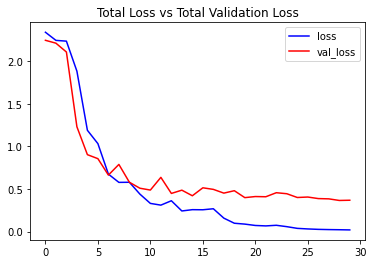

In [37]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

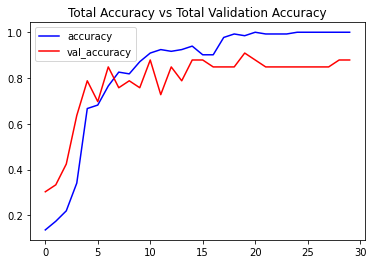

In [38]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [39]:

label_map = {
    'Writing On Board': "abnormal",
    'Argue': "abnormal",
    'Hand Raise': "normal",
    'Eating In Class': "abnormal",
    'Sitting On Desk': "abnormal",
    'Holding Book': "normal",
    'Holding Mobile': "abnormal",
    'Writing On Textbook': "normal",
    'Reading Book': "normal",
    'Explainig The Subject': "normal"
}

print("Test set shape:", features_test.shape)
predictions = LRCN_model.predict(features_test)

print("Predicted\t\tActual")
for prediction, labels_gt in zip(predictions, labels_test):
  gt_class_index = np.argmax(labels_gt)
  gt_class = CLASSES_LIST[gt_class_index]
  category_gt = label_map[gt_class]

  predicted_class_index = np.argmax(prediction)
  predicted_class = CLASSES_LIST[predicted_class_index]
  category_pred = label_map[predicted_class]

  print(f"{category_pred}: {predicted_class}\t\t{category_gt}: {gt_class}")

Test set shape: (56, 16, 128, 128, 3)
2/2 [==============================] - 1s 31ms/step
Predicted		Actual
normal: Explainig The Subject		abnormal: Holding Mobile
abnormal: Holding Mobile		abnormal: Holding Mobile
abnormal: Holding Mobile		abnormal: Eating In Class
abnormal: Sitting On Desk		abnormal: Sitting On Desk
abnormal: Argue		abnormal: Argue
normal: Explainig The Subject		normal: Holding Book
abnormal: Eating In Class		abnormal: Eating In Class
normal: Hand Raise		normal: Hand Raise
abnormal: Holding Mobile		abnormal: Holding Mobile
normal: Writing On Textbook		normal: Writing On Textbook
normal: Reading Book		normal: Reading Book
normal: Explainig The Subject		normal: Explainig The Subject
abnormal: Holding Mobile		abnormal: Holding Mobile
normal: Explainig The Subject		normal: Explainig The Subject
normal: Hand Raise		normal: Hand Raise
abnormal: Argue		abnormal: Argue
abnormal: Sitting On Desk		abnormal: Sitting On Desk
abnormal: Writing On Board		abnormal: Writing On Board

In [ ]:
import cv2

source = 0
cap = cv2.VideoCapture(source)

buffer = []
while True:
  ret, frame = cap.read()

  if ret:
    # Resize the Frame to fixed height and width.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    buffer.append(normalized_frame)
    if len(buffer) == SEQUENCE_LENGTH:
      ...

    else:
      continue